# I. Problem statement

Dataset: https://archive.ics.uci.edu/ml/datasets/Adult

Prediction task is to determine whether a person makes over 50K a year.

* Class probabilities for adult.all file
* Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
* Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)

Description of fnlwgt (final weight)

The weights on the CPS files are controlled to independent estimates of the
civilian noninstitutional population of the US.  These are prepared monthly
for us by Population Division here at the Census Bureau.  We use 3 sets of
controls.
  These are:
          1.  A single cell estimate of the population 16+ for each state.
          2.  Controls for Hispanic Origin by age and sex.
          3.  Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through
them 6 times so that by the end we come back to all the controls we used.

The term estimate refers to population totals derived from CPS by creating
"weighted tallies" of any specified socio-economic characteristics of the
population.

People with similar demographic characteristics should have
similar weights.  There is one important caveat to remember
about this statement.  That is that since the CPS sample is
actually a collection of 51 state samples, each with its own
probability of selection, the statement only applies within
state.



# II. Variables

* age: continuous.

* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.

* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.

* education-num: continuous.

* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.

* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.

* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.

* sex: Female, Male.

* capital-gain: continuous.

* capital-loss: continuous.

* hours-per-week: continuous.

* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

# III. Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.simplefilter('ignore')

colNames = ['Age', 'WorkClass', 'FnlWgt', 'Education', 'Education-Num', 'Marital-Status', 'Occupation', 
            'Relationship', 'Race', 'Sex', 'Capital-Gain', 'Capital-Loss', 'Hours-Per-Week', 'Native-Country', 'Salary']
dataset_train = pd.read_csv('data/adult-train.csv', header=None, names = colNames)
dataset_train.head(10)

dataset_test = pd.read_csv('data/adult-test.csv', header=None, names = colNames)
dataset_test.head(10)

,Age,WorkClass,FnlWgt,Education,Education-Num,Marital-Status,Occupation,Relationship,Race,Sex,Capital-Gain,Capital-Loss,Hours-Per-Week,Native-Country,Salary
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K.
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K.
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K.
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K.


# IV. Data preprocessing

## a) Charts

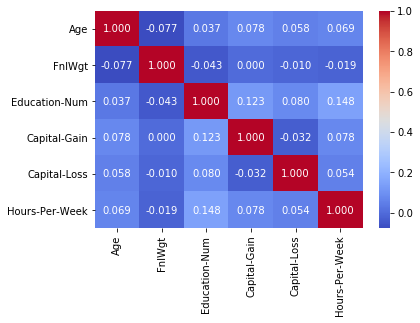

In [2]:
import seaborn as sns

cor_mat = dataset_train.corr()
sns.heatmap(cor_mat, annot=True, fmt='.3f', cmap='coolwarm')

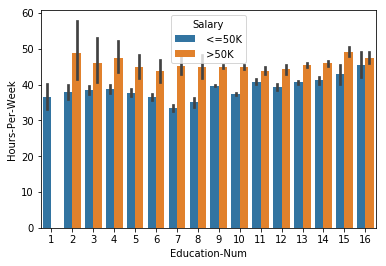

In [3]:
sns.barplot(x='Education-Num', y='Hours-Per-Week', hue='Salary', data=dataset_train)

Only 'Preschool' education has income <= 50k

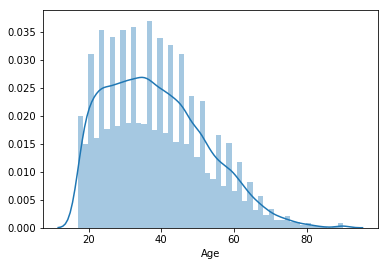

In [4]:
sns.distplot(dataset_train['Age'].dropna(), kde=True)

Almost of data sample has age from 25 to 50.

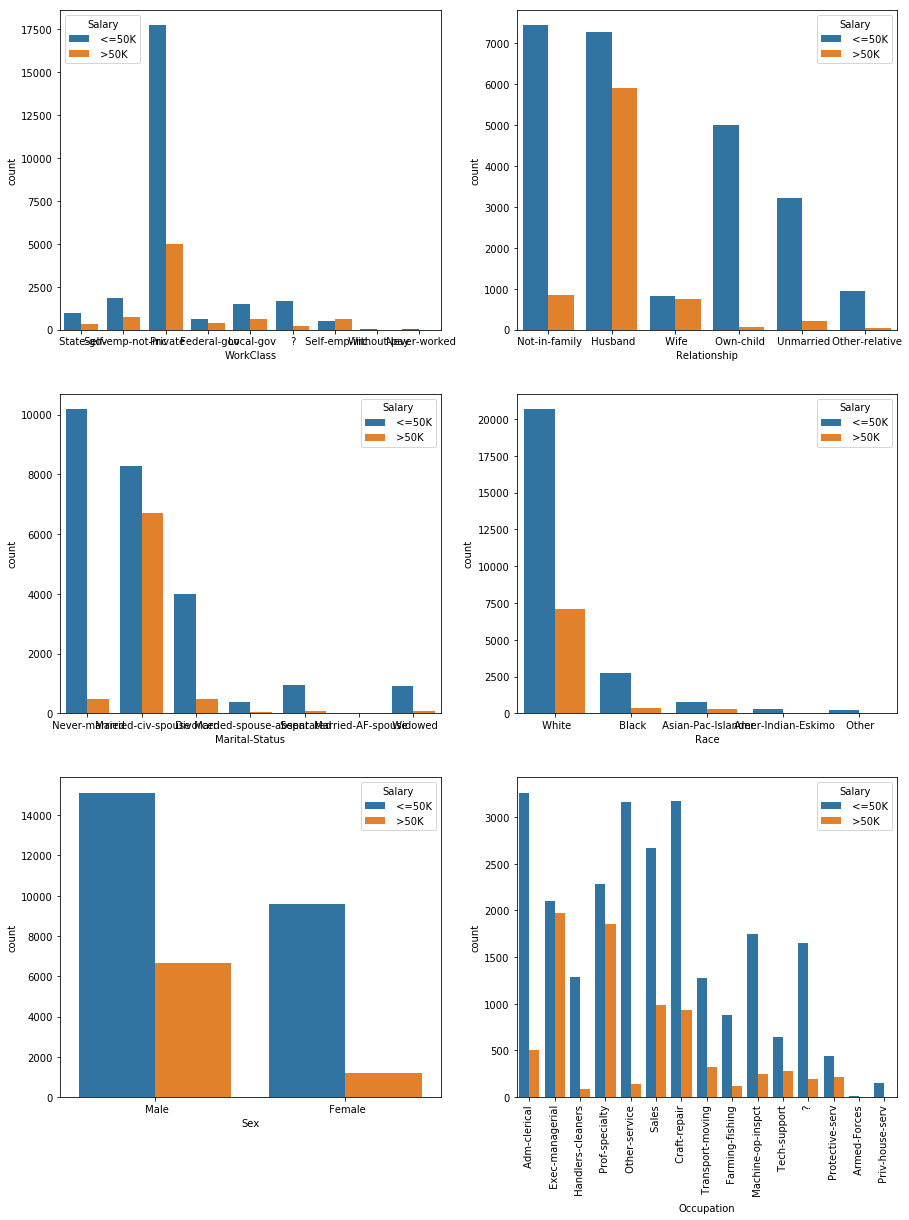

In [5]:
fig, ((a,b),(c,d),(e,f)) = plt.subplots(3,2,figsize=(15,20))

sns.countplot(x='WorkClass', hue='Salary',data = dataset_train, ax=a)
sns.countplot(x='Relationship', hue='Salary', data = dataset_train, ax=b)
sns.countplot(x='Marital-Status', hue='Salary', data = dataset_train, ax=c)
sns.countplot(x='Race', hue='Salary', data = dataset_train, ax=d)
sns.countplot(x='Sex', hue='Salary', data = dataset_train, ax=e)
sns.countplot(x='Occupation', hue='Salary', data = dataset_train, ax=f)
plt.xticks(rotation=90)
plt.show()

- Work class private has highest income
- Male also has higher income than female
- Exec-managerial and Prof-specialty have highest income

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]),
 <a list of 42 Text xticklabel objects>)

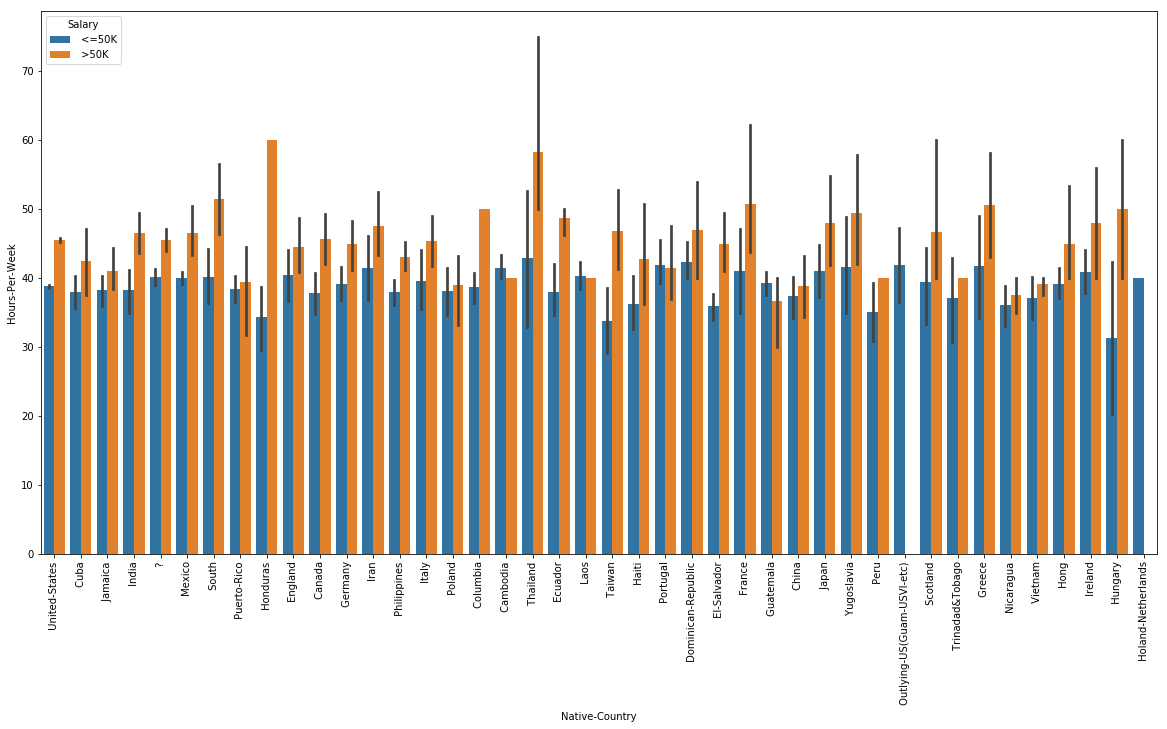

In [6]:
f,ax = plt.subplots(figsize=(20,10))
sns.barplot(x='Native-Country', y='Hours-Per-Week', hue='Salary', data=dataset_train)
plt.xticks(rotation=90)

- Almost of data sample have high hour working.
- The higher hour working, the higher income.

## b) Data Wrangling

* We tranform the 'Salary' attribute to the categorial values 'Yes' if people salary is greater than 50 K, 'No' if otherwise.

* Remove the redundant column 'Education' which is covered by the column 'Education-Num'

* Remove unknown data from both train and test data

* Normalize data

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Check code https://www.kaggle.com/jeffd23/scikit-learn-ml-from-start-to-finish#Some-Final-Encoding to encode the 
# category values to numerical values


labelEncoder = LabelEncoder()    
dataset_train = dataset_train.apply(labelEncoder.fit_transform)
dataset_test = dataset_test.apply(labelEncoder.fit_transform)

dropColumns = ['Salary', 'Education']
X_train = dataset_train.drop(dropColumns, axis=1)
Y_train = dataset_train['Salary']

X_test = dataset_test.drop(dropColumns, axis=1)
Y_test = dataset_test['Salary']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


# V. Algorithms

## Common method

Define the common methods for later usages such as calculate learning curve, validation curve, draw the graph, etc.

In [8]:
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def bestParamsClassifier(classifier, params):
    # Type of scoring used to compare parameter combinations
    acc_scorer = make_scorer(accuracy_score)
    # Run the grid search
    grid_obj = GridSearchCV(classifier, parameters, scoring=acc_scorer)
    grid_obj.fit(X_train, Y_train)

    # Set the clf to the best combination of parameters
    classifier = grid_obj.best_estimator_
    return classifier

from sklearn.model_selection import learning_curve

def callLearningCurve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring='accuracy',
                                                           train_sizes=np.linspace(0.1, 1.0, 20), cv=None)
    return train_sizes, train_scores, test_scores

def plotLearningCurve(title, train_sizes, train_scores, test_scores):
    # Calculate mean and standard deviation for training set scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    # Calculate mean and standard deviation for test set scores
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    f,ax = plt.subplots(figsize=(20,10))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    # Plot mean accuracy scores for training and test sets
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    # Plot accurancy bands for training and test sets
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    

    plt.legend(loc="best")
    plt.show()

from sklearn.model_selection import validation_curve

def callValidationCurve(estimator, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name, param_range, scoring='accuracy')
    return train_scores, test_scores

def plotValidationCurve(param_range, train_scores, test_scores):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    f,ax = plt.subplots(figsize=(20,10))
    plt.title("Validation Curve")
    plt.xlabel("Model Complexity")
    plt.ylabel("Score")

    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
             color="r", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1,
                 color="g", lw=lw)
    plt.legend(loc="best")
    plt.show() 

## a) Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

lg_classifier = LogisticRegression()
lg_classifier.fit(X_train, Y_train)
Y_lg_pred = lg_classifier.predict(X_test)
Y_lg_pred_proba = lg_classifier.predict_proba(X_test)
print(accuracy_score(Y_test, Y_lg_pred))
print(classification_report(Y_test, Y_lg_pred))


0.8227381610466188
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     12435
           1       0.70      0.44      0.54      3846

   micro avg       0.82      0.82      0.82     16281
   macro avg       0.77      0.69      0.71     16281
weighted avg       0.81      0.82      0.81     16281



### Validation Curve

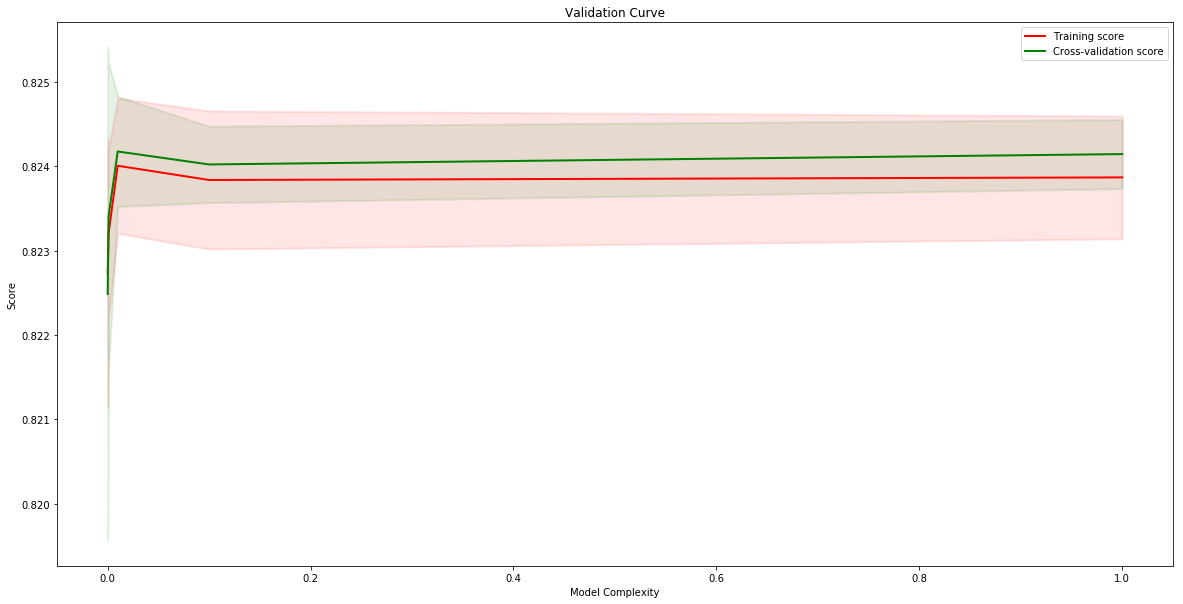

In [10]:
param_range = [0.0001, 0.001,0.01,0.1,1]
train_scores, test_scores = callValidationCurve(LogisticRegression(), X_train, Y_train, param_name='C', 
                                               param_range=param_range)
plotValidationCurve(param_range, train_scores, test_scores)

### Learning Curve

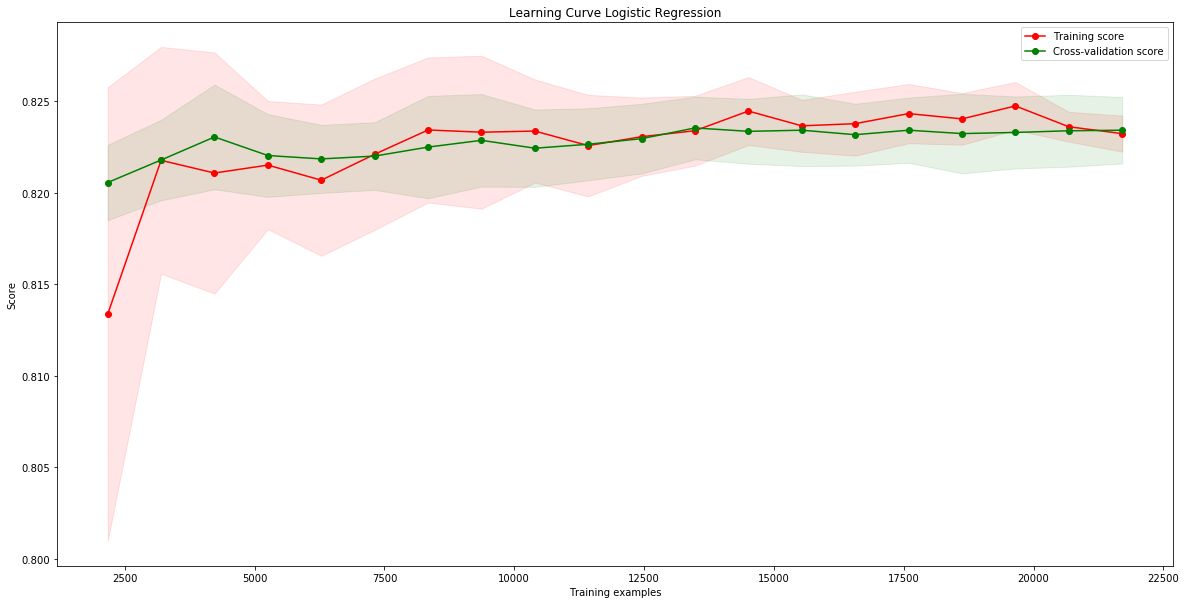

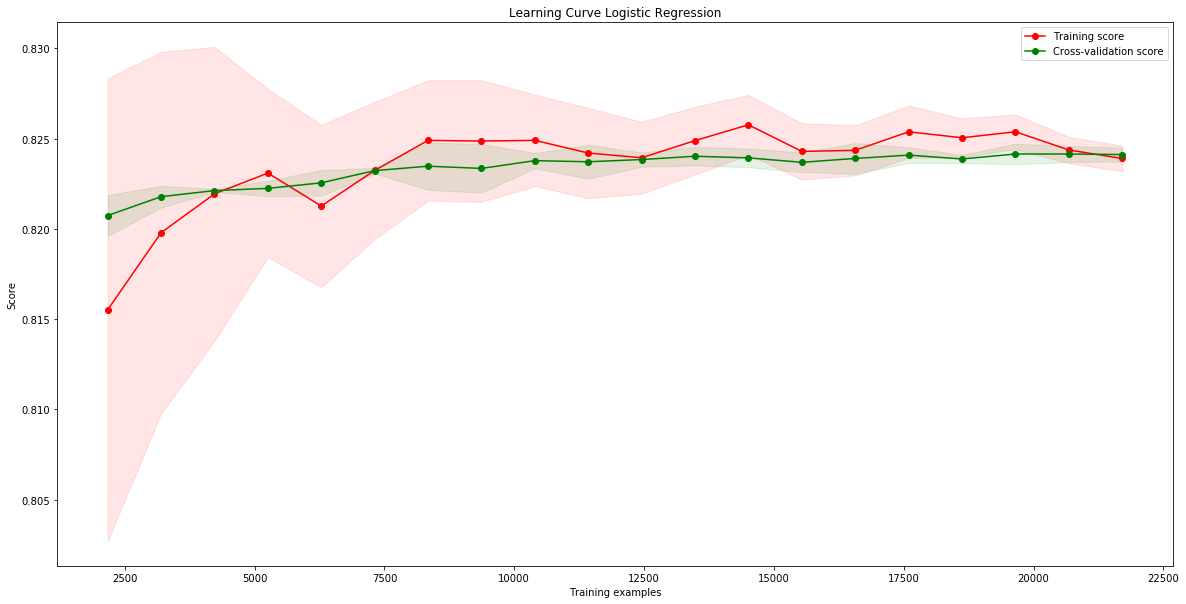

In [11]:
train_sizes, train_scores, test_scores = callLearningCurve(LogisticRegression(C=0.001), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(LogisticRegression(C=1), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

## b)  KNN


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# validation_curve(KNeighborsClassifier(), X_train, Y_train, cv = 3)
# Reference: https://www.dataquest.io/blog/learning-curves-machine-learning/
#train_sizes, train_scores, validation_scores = learning_curve(KNeighborsClassifier(), X_train, Y_train, , cv = 3)

neighbors = [3, 5, 7]
for n_neighbors in neighbors:
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train, Y_train)
    Y_knn_pred = knn_classifier.predict(X_test)
    Y_knn_pred_proba = knn_classifier.predict_proba(X_test)
    print("KNN with neighbors ", n_neighbors)
    print(accuracy_score(Y_test, Y_knn_pred))
    print(classification_report(Y_test, Y_knn_pred))
    


KNN with neighbors  3
0.8273447576930164
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     12435
           1       0.65      0.59      0.62      3846

   micro avg       0.83      0.83      0.83     16281
   macro avg       0.76      0.74      0.75     16281
weighted avg       0.82      0.83      0.82     16281

KNN with neighbors  5
0.8360051593882439
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     12435
           1       0.67      0.60      0.63      3846

   micro avg       0.84      0.84      0.84     16281
   macro avg       0.78      0.75      0.76     16281
weighted avg       0.83      0.84      0.83     16281

KNN with neighbors  7
0.8428229224249125
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.69      0.60      0.65      3846

   micro avg       0.84      0.84      0.84     16281
   ma

The best hyperparameter is n_neighbors = 7

### Validation Curve

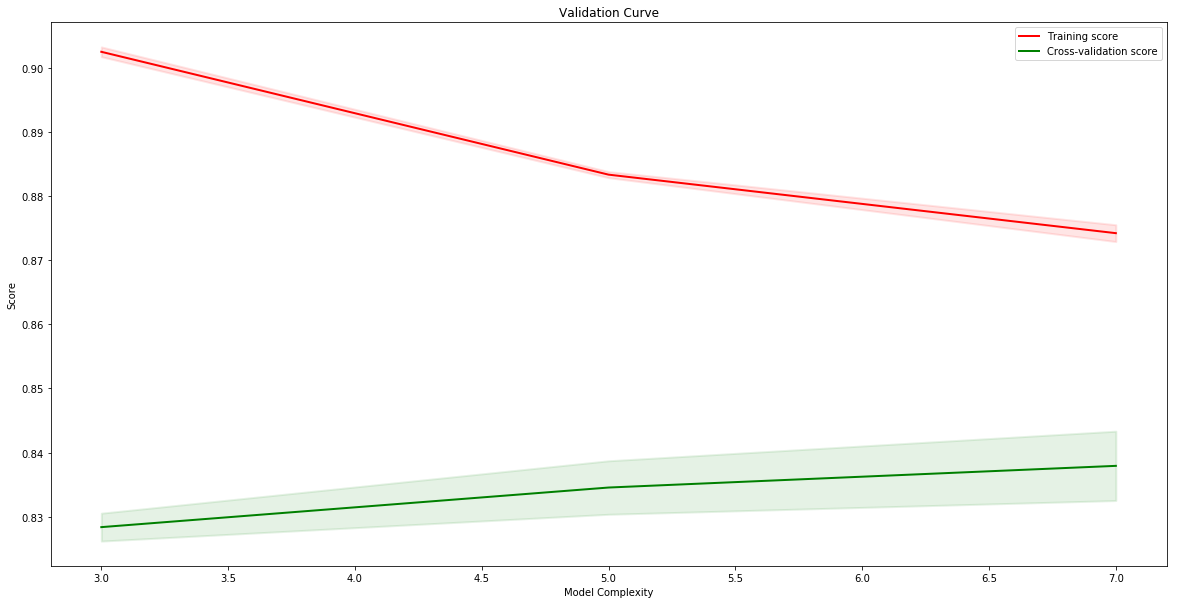

In [13]:
train_scores, test_scores = callValidationCurve(KNeighborsClassifier(), X_train, Y_train, "n_neighbors", neighbors)
plotValidationCurve(neighbors, train_scores, test_scores)

### Learning Curve

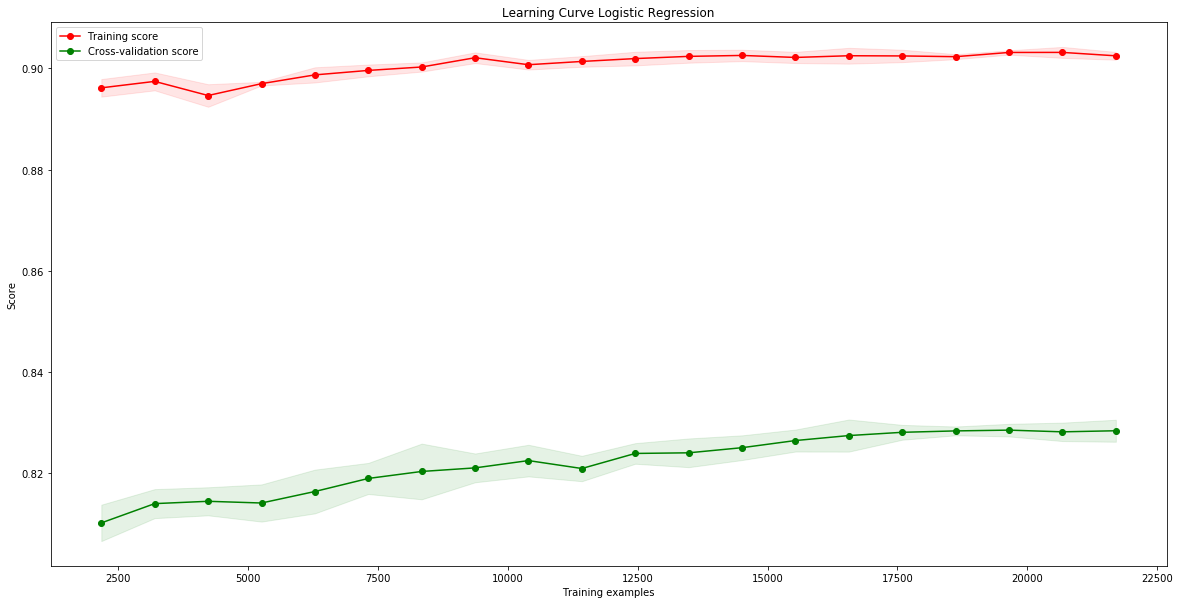

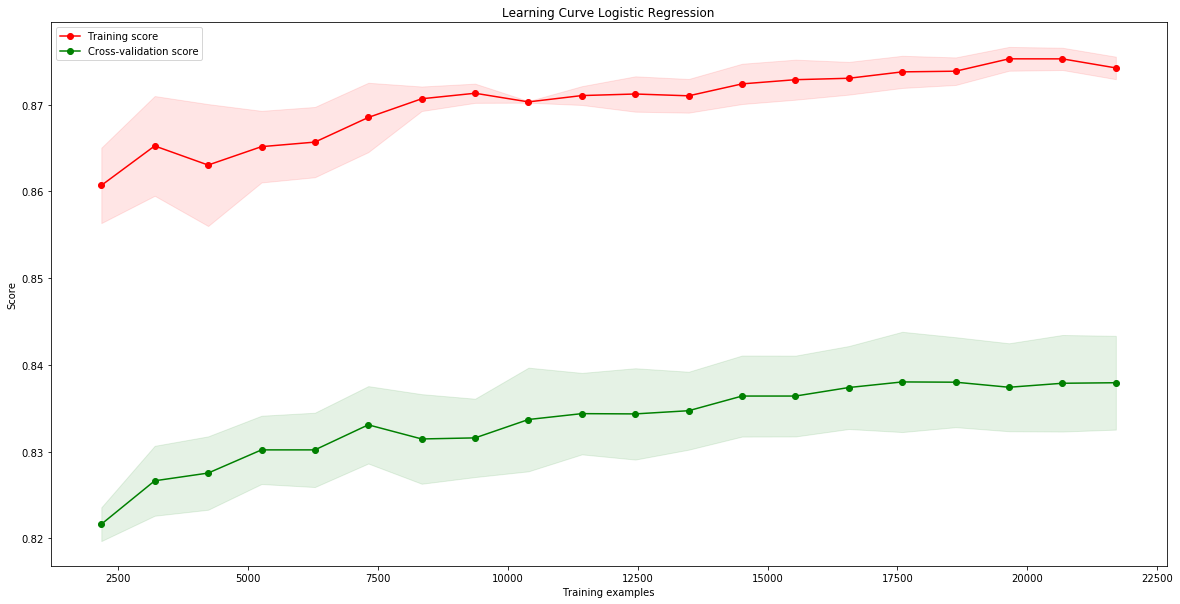

In [14]:
train_sizes, train_scores, test_scores = callLearningCurve(KNeighborsClassifier(n_neighbors=3), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(KNeighborsClassifier(n_neighbors=7), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

## c) Decision tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

for i in [4, 5, 6]:
    dt_classifier = DecisionTreeClassifier(max_depth=i)
    dt_classifier.fit(X_train, Y_train)
    Y_dt_pred = dt_classifier.predict(X_test)
    Y_dt_pred_proba = dt_classifier.predict_proba(X_test)
    print("Decision tree with max_dept ", i)
    print(classification_report(Y_test, Y_dt_pred))


Decision tree with max_dept  4
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     12435
           1       0.75      0.50      0.60      3846

   micro avg       0.84      0.84      0.84     16281
   macro avg       0.80      0.72      0.75     16281
weighted avg       0.83      0.84      0.83     16281

Decision tree with max_dept  5
              precision    recall  f1-score   support

           0       0.86      0.95      0.91     12435
           1       0.77      0.51      0.61      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.82      0.73      0.76     16281
weighted avg       0.84      0.85      0.84     16281

Decision tree with max_dept  6
              precision    recall  f1-score   support

           0       0.86      0.96      0.91     12435
           1       0.78      0.51      0.62      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.82      0.73  

### Validation Curve

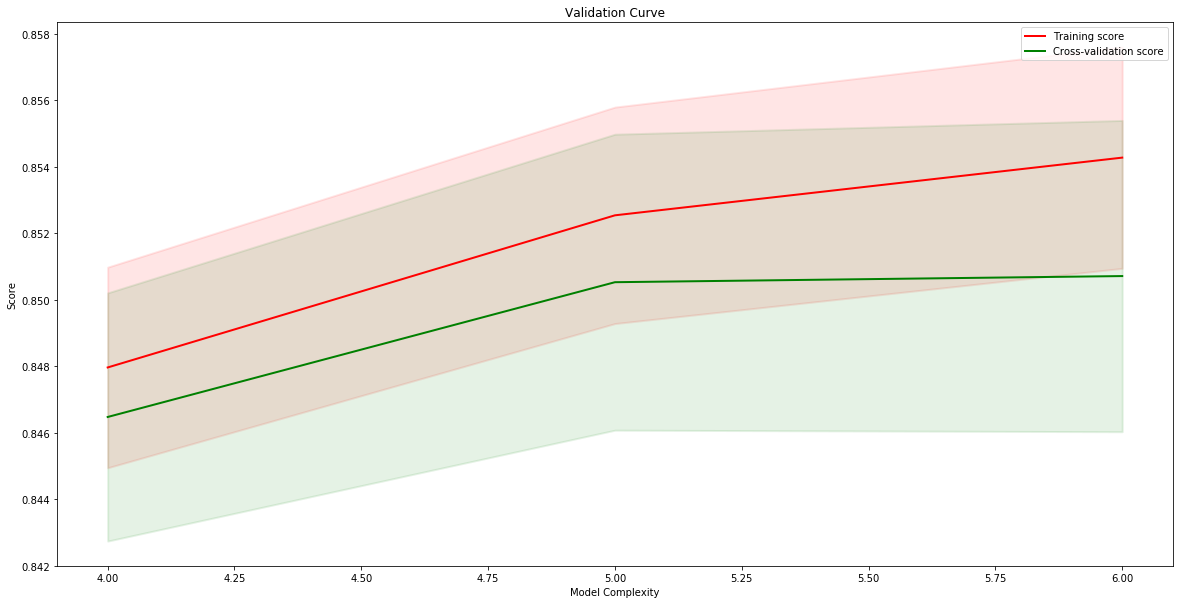

In [16]:
train_scores, test_scores = callValidationCurve(DecisionTreeClassifier(), X_train, Y_train, "max_depth", [4, 5, 6])
plotValidationCurve([4, 5, 6], train_scores, test_scores)

### Learning curve

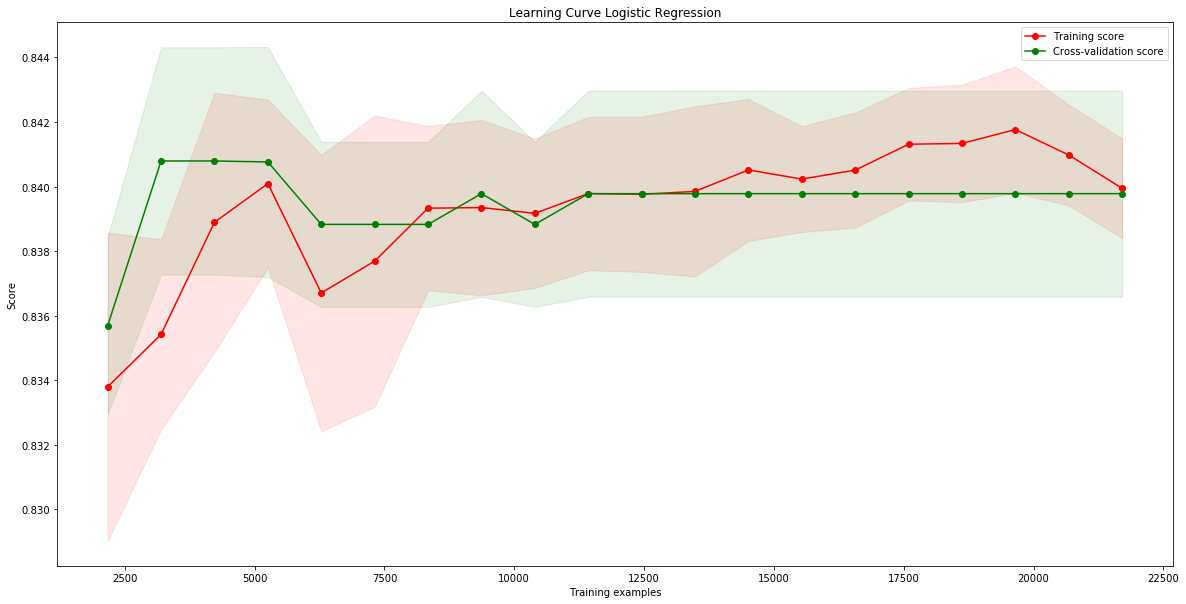

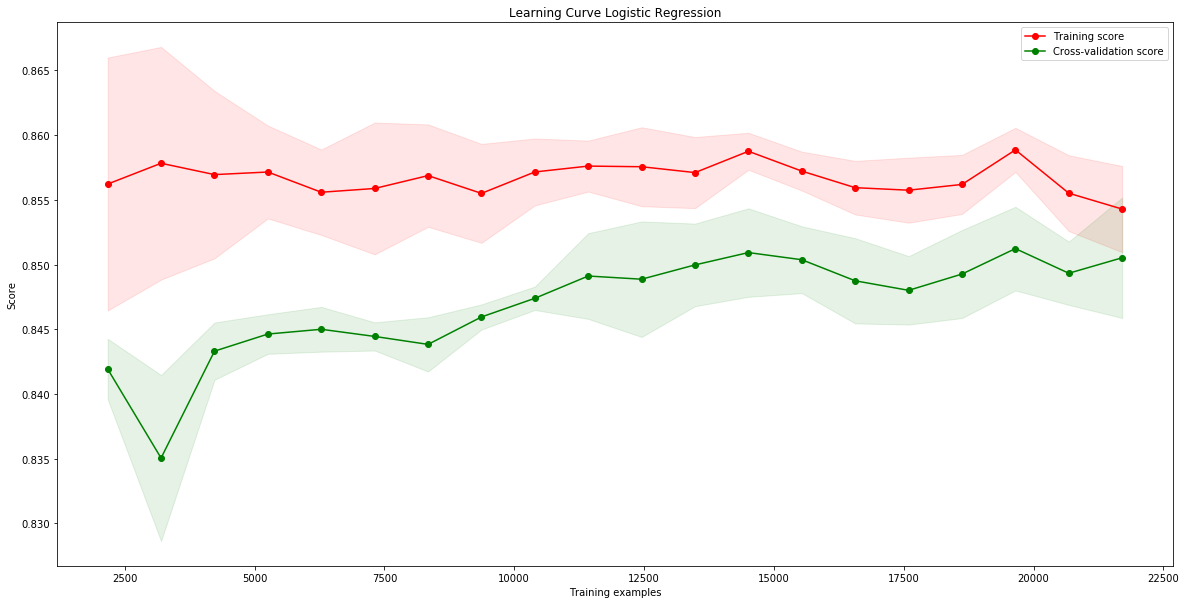

In [17]:
train_sizes, train_scores, test_scores = callLearningCurve(DecisionTreeClassifier(max_depth=3), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(DecisionTreeClassifier(max_depth=6), X_train, Y_train)
plotLearningCurve('Learning Curve Logistic Regression', train_sizes, train_scores, test_scores)

## d) Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

estimators = [30, 60, 90]
for n_estimators in estimators:
    rd_classifier = RandomForestClassifier(n_estimators=n_estimators)
    rd_classifier.fit(X_train, Y_train)
    Y_rf_pred = rd_classifier.predict(X_test)
    Y_rf_pred_proba = rd_classifier.predict_proba(X_test)
    print(classification_report(Y_test, Y_rf_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91     12435
           1       0.75      0.56      0.64      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.81      0.75      0.77     16281
weighted avg       0.84      0.85      0.84     16281

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12435
           1       0.74      0.57      0.64      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.81      0.75      0.77     16281
weighted avg       0.84      0.85      0.84     16281

              precision    recall  f1-score   support

           0       0.87      0.94      0.91     12435
           1       0.75      0.56      0.64      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.81      0.75      0.78     16281
weighted avg       0.85      0.85      0.84     16281



### Validation Curve

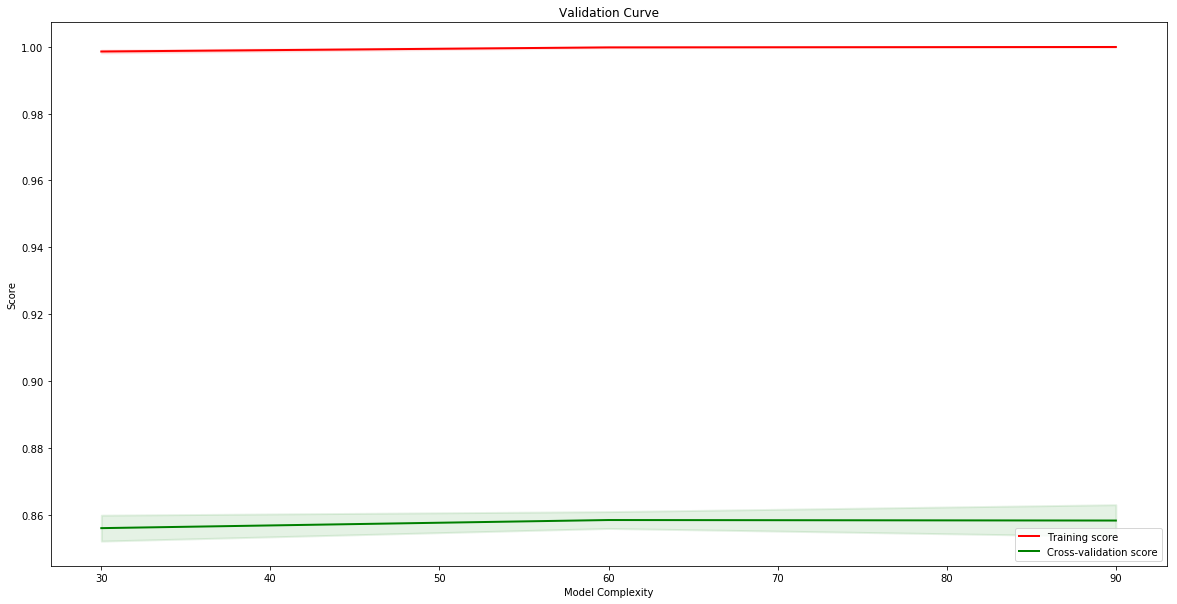

In [19]:
train_scores, test_scores = callValidationCurve(RandomForestClassifier(), X_train, Y_train,
                                                "n_estimators", estimators)
plotValidationCurve(estimators, train_scores, test_scores)

### Learning curve

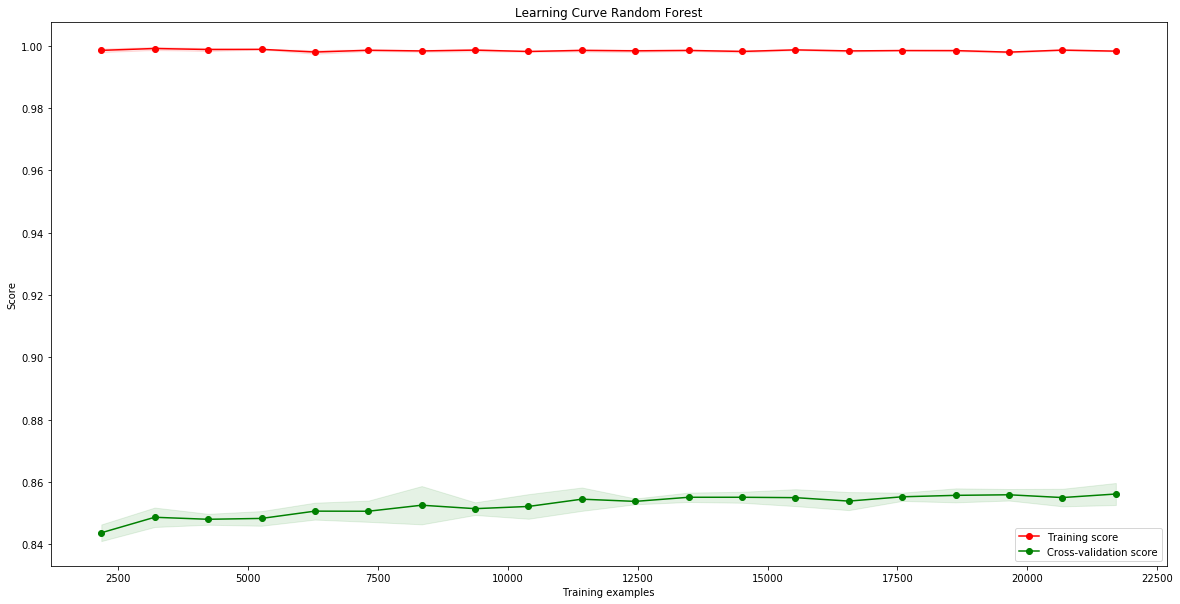

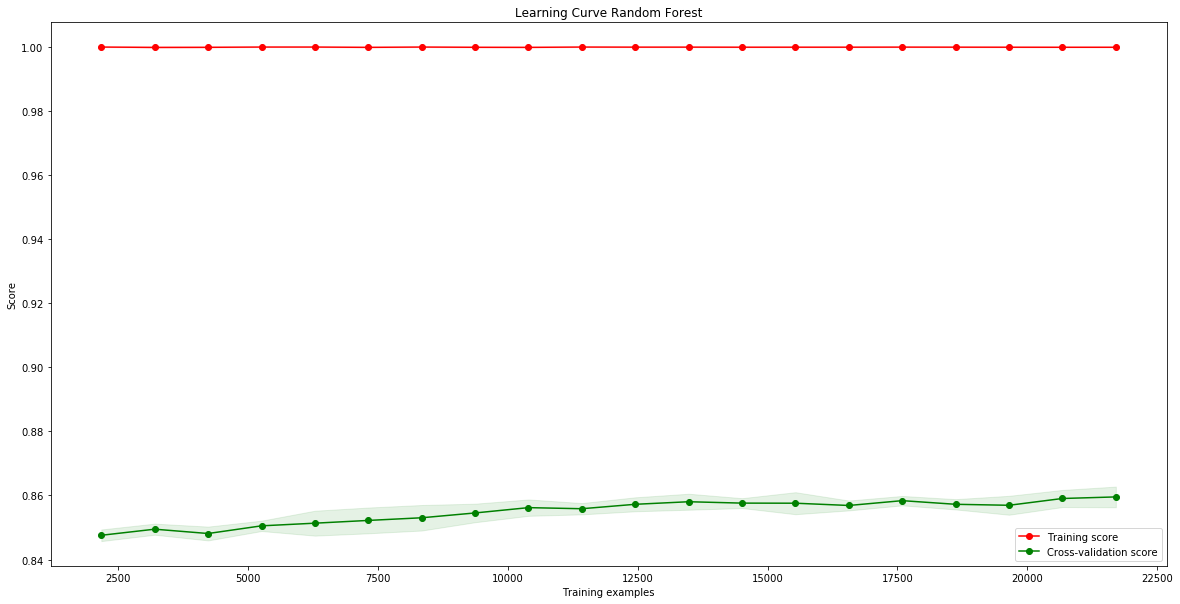

In [20]:
train_sizes, train_scores, test_scores = callLearningCurve(RandomForestClassifier(n_estimators=30), X_train, Y_train)
plotLearningCurve('Learning Curve Random Forest', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(RandomForestClassifier(n_estimators=90), X_train, Y_train)
plotLearningCurve('Learning Curve Random Forest', train_sizes, train_scores, test_scores)

## e) AdaBoost

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

estimators = [3,5,7,9]
for n_estimators in estimators:
    ada_classifier = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=0.5)
    ada_classifier.fit(X_train, Y_train)
    Y_ada_pred = ada_classifier.predict(X_test)
    Y_ada_pred_proba = ada_classifier.predict_log_proba(X_test)
    print(metrics.accuracy_score(Y_test, Y_ada_pred))
    print(classification_report(Y_test, Y_ada_pred))

0.8148148148148148
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     12435
           1       0.71      0.36      0.48      3846

   micro avg       0.81      0.81      0.81     16281
   macro avg       0.77      0.66      0.68     16281
weighted avg       0.80      0.81      0.79     16281

0.8363122658313371
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     12435
           1       0.76      0.45      0.56      3846

   micro avg       0.84      0.84      0.84     16281
   macro avg       0.81      0.70      0.73     16281
weighted avg       0.83      0.84      0.82     16281

0.8363122658313371
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     12435
           1       0.76      0.45      0.56      3846

   micro avg       0.84      0.84      0.84     16281
   macro avg       0.81      0.70      0.73     16281
weighted avg     

Read the classification report, we see the best hyper-parameter for Adaboost classifier is 'n_estimators = 9' and the worst is 'n_estimators = 3'

### Validation Curve

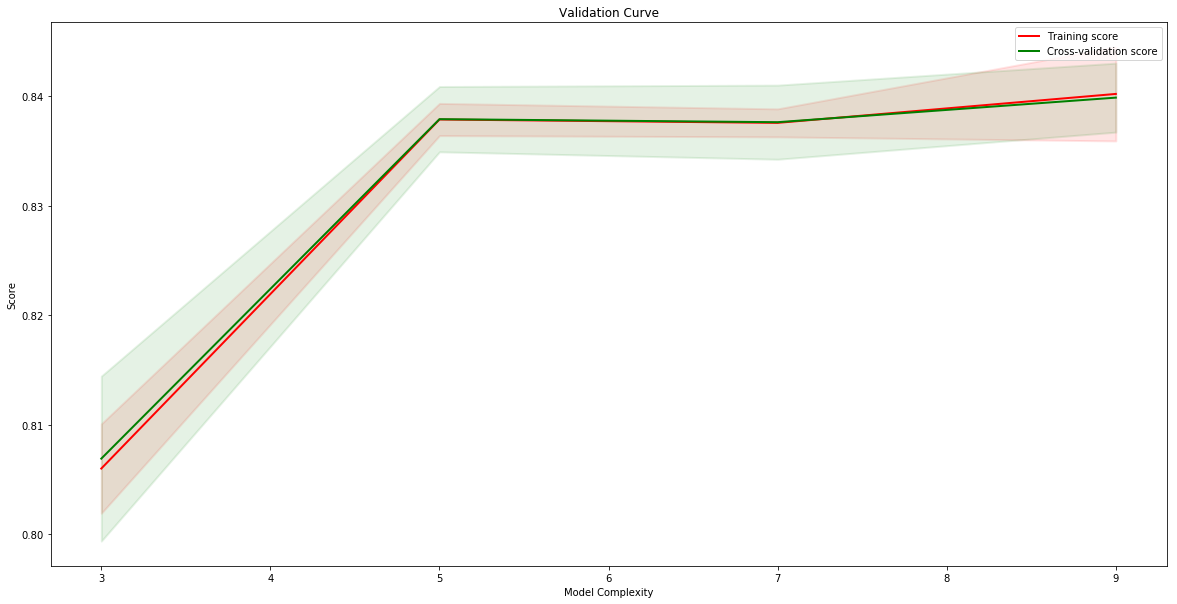

In [24]:
train_scores, test_scores = callValidationCurve(AdaBoostClassifier(learning_rate=0.5), X_train, Y_train,
                                                "n_estimators", estimators)
plotValidationCurve(estimators, train_scores, test_scores)

### Learning curve

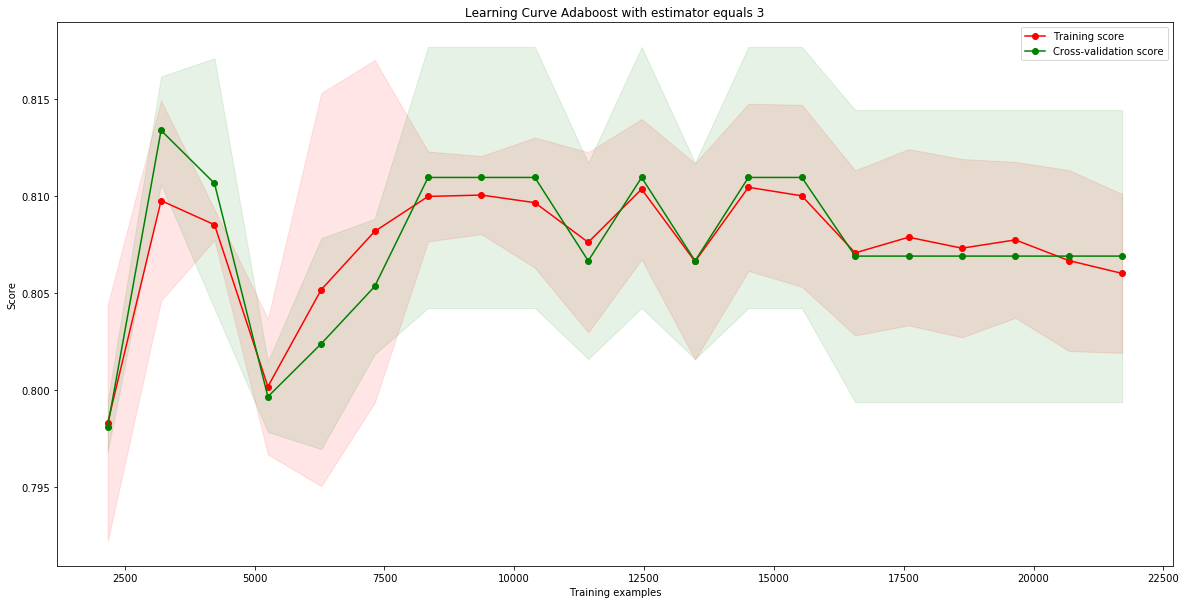

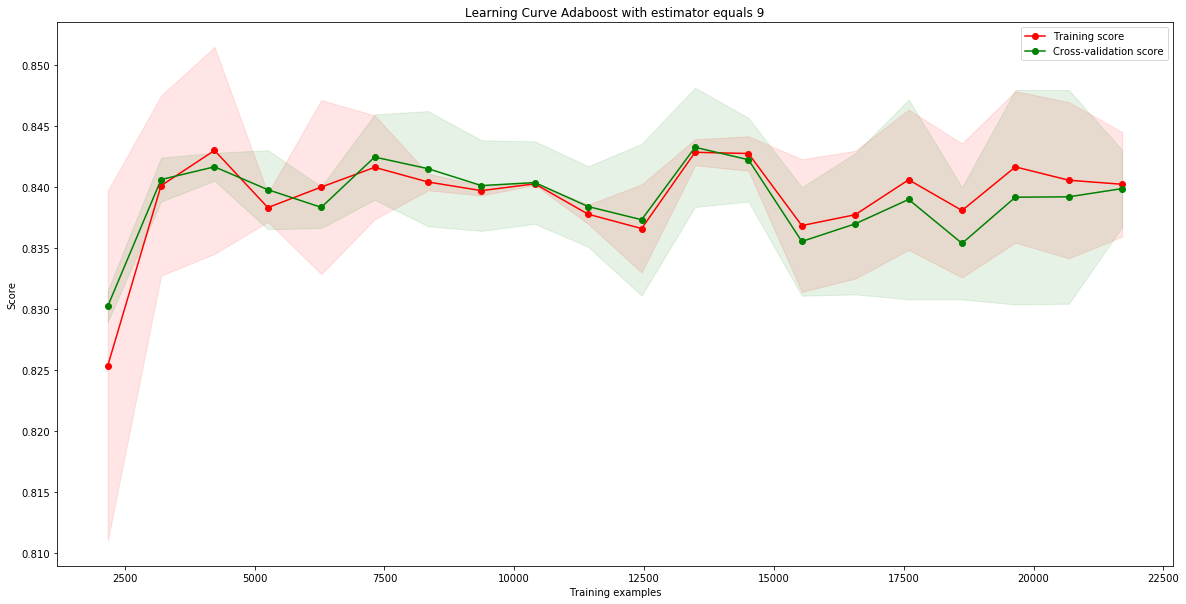

In [25]:
train_sizes, train_scores, test_scores = callLearningCurve(AdaBoostClassifier(n_estimators=3, 
                                                                              learning_rate=0.5), X_train, Y_train)
plotLearningCurve('Learning Curve Adaboost with estimator equals 3', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(AdaBoostClassifier(n_estimators=9, 
                                                                              learning_rate=0.5), X_train, Y_train)
plotLearningCurve('Learning Curve Adaboost with estimator equals 9', train_sizes, train_scores, test_scores)

## f) Neural Network 

In [27]:
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

iterators = [100, 300, 500]

for max_iter in iterators:
    mlp_classifier = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=max_iter)
    mlp_classifier.fit(X_train, Y_train)
    Y_nn_pred = mlp_classifier.predict(X_test)
    Y_nn_pred_proba = mlp_classifier.predict_proba(X_test)
    print(metrics.accuracy_score(Y_test, Y_nn_pred))
    print(classification_report(Y_test, Y_nn_pred))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.8531416989128432
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     12435
           1       0.75      0.56      0.64      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.81      0.75      0.78     16281
weighted avg       0.85      0.85      0.85     16281

0.8514219028315214
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     12435
           1       0.75      0.55      0.64      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.81      0.75      0.77     16281
weighted avg       0.84      0.85      0.84     16281

0.8528960137583687
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12435
           1       0.74      0.58      0.65      3846

   micro avg       0.85      0.85      0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg     

Read the classification report, the best value for nueral network is max_iter = 500

### Validation Curve

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


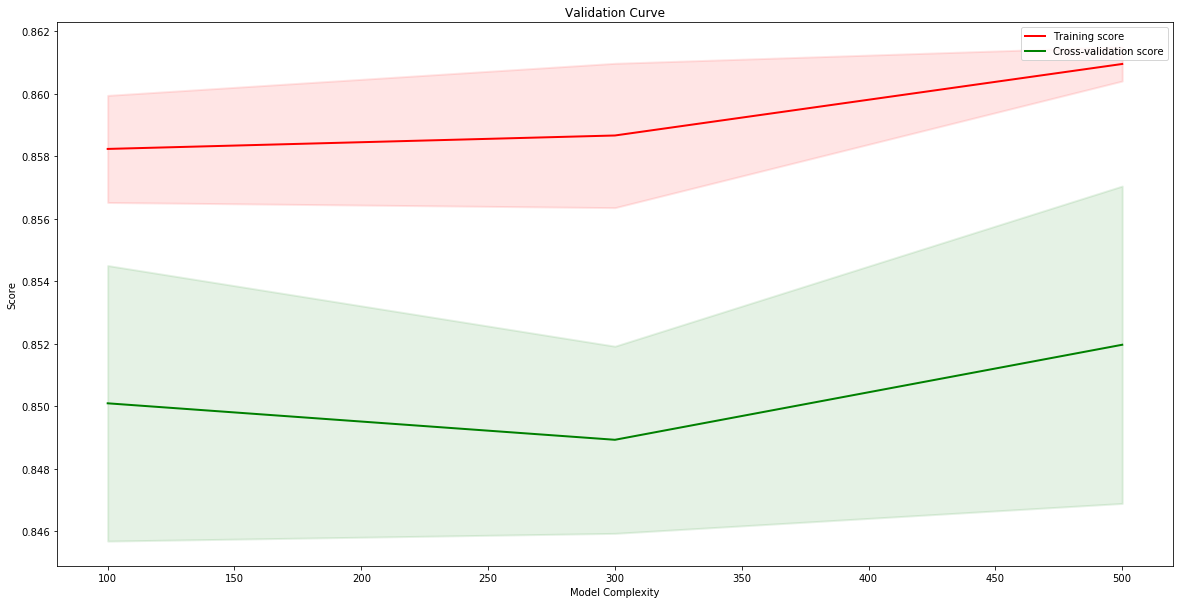

In [28]:
train_scores, test_scores = callValidationCurve(MLPClassifier(hidden_layer_sizes=(13,13,13)), X_train, Y_train,
                                                "max_iter", iterators)
plotValidationCurve(iterators, train_scores, test_scores)

### Learning Curve

In [ ]:
train_sizes, train_scores, test_scores = callLearningCurve(MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=100), X_train, Y_train)
plotLearningCurve('Learning Curve Neural Network', train_sizes, train_scores, test_scores)

train_sizes, train_scores, test_scores = callLearningCurve(MLPClassifier(hidden_layer_sizes=(13,13,13), max_iter=500), X_train, Y_train)
plotLearningCurve('Learning Curve Neural Network', train_sizes, train_scores, test_scores)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# VI. AUC

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

f,ax = plt.subplots(figsize=(15,15))
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
preds = {"Linear Regression": Y_lg_pred_proba[:, 1], 
         "KNN": Y_knn_pred_proba[:, 1], 
         "Decision Tree": Y_dt_pred_proba[:, 1], 
         "Random Forest": Y_rf_pred_proba[:, 1], 
         "AdaBoost": Y_ada_pred_proba[:, 1], 
         "Nueral Networks": Y_nn_pred_proba[:, 1]}

for algorithm, pred in preds.items():
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(Y_test, pred)
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.', label = algorithm)

plt.legend(loc="lower right")
# show the plot
plt.show()

In [ ]:
# from autosklearn.classification import AutoSklearnClassifier

# cls = AutoSklearnClassifier(include_estimators=['lda','k_nearest_neighbors','passive_aggressive','gradient_boosting','extra_trees','liblinear_svc'], 
#                               resampling_strategy='cv',
#                             resampling_strategy_arguments={'folds': 5}, ml_memory_limit=222000)
# cls.fit(X_train, Y_train)
# predictions = cls.predict(X_test)

# VII. References

1. [Plot validation curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html)

2. [Learning curve machine learning](https://www.dataquest.io/blog/learning-curves-machine-learning/)

3. [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)